# Imports

In [114]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import tensorflow_probability as tfp
from keras.models import Model
from keras.layers import Layer
from keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,LeakyReLU)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.optimizers import Adam
from keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from keras.regularizers import L2, L1
from keras.initializers import RandomNormal
import os


# Dataset extraction

In [115]:
images = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/images'
annotations = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/annotations'

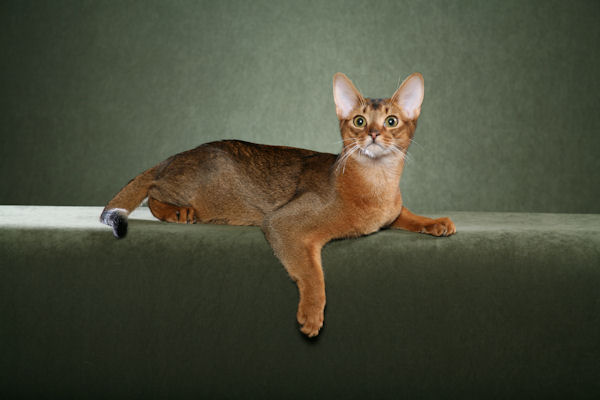

In [116]:
img = tf.keras.preprocessing.image.load_img('/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/images/Abyssinian_1.jpg')
display(img)

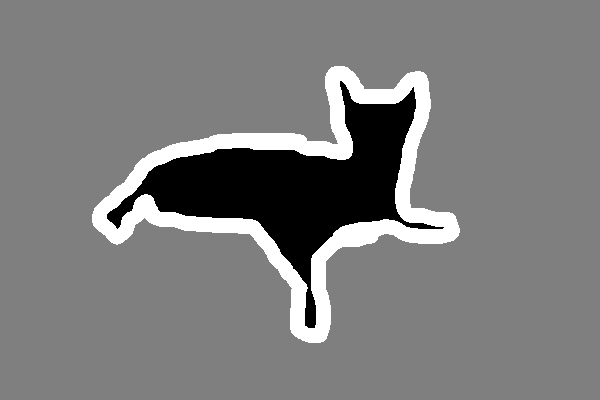

In [117]:
img = keras.preprocessing.image.load_img('/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/annotations/trimaps/Abyssinian_1.png')
img = ImageOps.autocontrast(img)
display(img)

# Data Preparation

In [237]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__ (self, images, maps, batch_size, INPUT_DIM, shuffle = False):

        self.images = images
        self.maps = maps
        self.batch_size = batch_size
        self.train_image_list=os.listdir(images)
        self.INPUT_DIM=INPUT_DIM

    def __len__(self):
        return int(np.floor(len(self.train_image_list)/self.batch_size))
  
    def __getitem__(self, idx):
        x,y = self.__data_generation(idx)
        y-=1
        return np.array(x), np.array(y)
  
    def __data_generation(self, idx):
        x = []
        y = []

        for j in range(idx*self.batch_size, (idx+1)*self.batch_size):
            x.append(img_to_array(load_img(self.images+os.listdir(self.images)[j],target_size=(self.INPUT_DIM,self.INPUT_DIM))))
            y.append(img_to_array(load_img(self.maps+os.listdir(self.maps)[j], color_mode='grayscale', target_size=(self.INPUT_DIM//2,self.INPUT_DIM//2))))
            
            return tf.convert_to_tensor(x),tf.convert_to_tensor(y)

# OS Dir copy

In [209]:
import os
import random
from shutil import copyfile

# Paths to the full dataset
full_dataset = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/images'
full_annotations = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/annotations/trimaps'

# Define the directories for the train and validation sets
train_dataset_dir = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/train/dataset'
train_annotations_dir = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/train/annotations'
val_dataset_dir = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/validation/dataset'
val_annotations_dir = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/validation/annotations'

# Create the train and validation directories if they don't exist
os.makedirs(train_dataset_dir, exist_ok=True)
os.makedirs(train_annotations_dir, exist_ok=True)
os.makedirs(val_dataset_dir, exist_ok=True)
os.makedirs(val_annotations_dir, exist_ok=True)

# Get a list of all image and annotation files in the full dataset
image_files = os.listdir(full_dataset)
annotation_files = os.listdir(full_annotations)

# Filter out any files that are not valid annotation files (e.g., ".DS_Store" files)
annotation_files = [file for file in annotation_files if file.endswith('.png')]

# Identify missing annotations
missing_annotations = [image_file for image_file in image_files if os.path.splitext(image_file)[0] + '.png' not in annotation_files]

# Remove missing annotations from image_files
image_files = [image_file for image_file in image_files if image_file not in missing_annotations]

# Define the proportion of data to use for validation (e.g., 20%)
validation_split = 0.5
train_split = 0.95

# Calculate the number of samples for validation
train_samples = int(len(image_files) * train_split)
num_validation_samples = int(validation_split * len(image_files))

# Split the files into training and validation sets
train_image_files = image_files[:train_samples]
val_image_files = image_files[train_samples:]

# Copy the selected images to the train and validation directories
for image_file in train_image_files:
    src_image_path = os.path.join(full_dataset, image_file)
    dest_image_path = os.path.join(train_dataset_dir, image_file)
    copyfile(src_image_path, dest_image_path)

for image_file in val_image_files:
    src_image_path = os.path.join(full_dataset, image_file)
    dest_image_path = os.path.join(val_dataset_dir, image_file)
    copyfile(src_image_path, dest_image_path)

# Copy the corresponding annotation files to the train and validation annotation directories
for image_file in train_image_files:
    annotation_file = os.path.splitext(image_file)[0] + '.png'
    src_annotation_path = os.path.join(full_annotations, annotation_file)
    dest_annotation_path = os.path.join(train_annotations_dir, annotation_file)
    copyfile(src_annotation_path, dest_annotation_path)

for image_file in val_image_files:
    annotation_file = os.path.splitext(image_file)[0] + '.png'
    src_annotation_path = os.path.join(full_annotations, annotation_file)
    dest_annotation_path = os.path.join(val_annotations_dir, annotation_file)
    copyfile(src_annotation_path, dest_annotation_path)

# Check the number of files in the train and validation directories
print("Total images:", len(image_files))
print("Train images:", len(train_image_files))
print("Validation images:", len(val_image_files))
print("Missing annotation for image:", missing_annotations)
print("Train dataset images:", len(os.listdir(train_dataset_dir)))
print("Train annotations:", len(os.listdir(train_annotations_dir)))
print("Validation dataset images:", len(os.listdir(val_dataset_dir)))
print("Validation annotations:", len(os.listdir(val_annotations_dir)))


Total images: 7390
Train images: 7020
Validation images: 370
Missing annotation for image: ['.DS_Store']
Train dataset images: 7020
Train annotations: 7020
Validation dataset images: 370
Validation annotations: 370


In [210]:
print(len(annotation_files))

7390


In [238]:
train_images = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/images'
train_maps = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/annotations'

# val_images = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/validation/dataset'
# val_maps = '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/validation/annotations'

BATCH_SIZE  = 4
LR = 1e-3
EPOCH = 100
INPUT_DIM = 224
NUM_FILTERS = 128

In [240]:
train_gen = DataGenerator(train_images, train_maps, BATCH_SIZE, INPUT_DIM)
# val_gen = DataGenerator(val_images, val_maps, BATCH_SIZE, INPUT_DIM)

# Modeling (UNET Model)

In [241]:
def get_base_model():

    base_model = tf.keras.applications.ResNet50(weights='imagenet', input_shape = (INPUT_DIM, INPUT_DIM, 3), include_top = False)

    # freeze base model    
    base_model.trainable = False
    

    conv1_relu,conv2_block3_out,conv3_block4_out,conv4_block6_out,conv5_block3_out=[base_model.get_layer(layer_name).output for layer_name in ["conv1_relu","conv2_block3_out","conv3_block4_out","conv4_block6_out","conv5_block3_out"]]
    # getting layer outputs and passing each output in the form of the size as seen in the model
    return Model(
        inputs=[base_model.inputs],outputs=[conv1_relu,conv2_block3_out,conv3_block4_out,conv4_block6_out,conv5_block3_out]
    )
get_base_model().summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_34[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [242]:
class Upsample(tf.keras.layers.Layer):
    def __init__(self,NUM_FILTERS):
        super(Upsample,self).__init__()
        self.conv_t_1=tf.keras.layers.Conv2DTranspose(NUM_FILTERS,1,strides=2,activation='relu')
        self.norm_1=BatchNormalization()
    def call(self,x):
        x=self.norm_1(self.conv_t_1(x))
        return x

In [243]:
class ConvLayers(tf.keras.layers.Layer):
    def __init__(self,NUM_FILTERS):
        super(ConvLayers,self).__init__()
        self.conv_1=Conv2D(NUM_FILTERS*2,3,padding='same',activation='relu')
        self.norm_1=BatchNormalization()
        
        self.conv_2=Conv2D(NUM_FILTERS*4,3,padding='same',activation='relu')
        self.norm_2=BatchNormalization()
    def call(self,x):
        x=self.norm_1(self.conv_1(x))
        x=self.norm_2(self.conv_2(x))
        return x

In [244]:
inputs=tf.keras.Input(shape=(INPUT_DIM,INPUT_DIM,3))
x=Rescaling(1/255.)(inputs)
x_112,x_56,x_28,x_14,x_7=get_base_model()(x)

x=Upsample(NUM_FILTERS)(x_7)
x=tf.concat([x,x_14],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)


x=Upsample(NUM_FILTERS)(x)
x=tf.concat([x,x_28],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)


x=Upsample(NUM_FILTERS)(x)
x=tf.concat([x,x_56],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)


x=Upsample(NUM_FILTERS)(x)
x=tf.concat([x,x_112],axis=-1)
x=ConvLayers(NUM_FILTERS)(x)

out=Conv2D(3,3,padding='same',activation='softmax')(x)
model=tf.keras.Model(inputs=inputs,outputs=out)
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_12 (Rescaling)    (None, 224, 224, 3)          0         ['input_35[0][0]']            
                                                                                                  
 model_32 (Functional)       [(None, 112, 112, 64),       2358771   ['rescaling_12[0][0]']        
                              (None, 56, 56, 256),        2                                       
                              (None, 28, 28, 512),                                                
                              (None, 14, 14, 1024),                                        

In [245]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = Adam(learning_rate = LR),
    metrics='accuracy',
    run_eagerly = True,
)

In [246]:
checkpoint_filepath='/Users/boss/Desktop/Python_files.nosync/Pretrained Models/UNET-Model'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

In [247]:
history = model.fit(
    train_gen,
    verbose=1,
    shuffle=True,
    epochs=EPOCH,
    callbacks=[callback])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/boss/Desktop/Python_files.nosync/Datasets/Oxford-IIIT-Pet/imagesEgyptian_Mau_167.jpg'

# Testing

In [ ]:
test_image ='...'
test_image_map='...'

X=[]
X.append(img_to_array(load_img(test_image,target_size=(224,224))))
image_output=tf.argmax(model.predict(tf.constant(X)),axis=-1)[0]
image_output=tf.expand_dims(image_output,axis=-1)

In [ ]:
image=tf.keras.preprocessing.image.load_img(test_image,color_mode='rgb',target_size=(224,224))
plt.imshow(image)
plt.show()

In [ ]:
plt.imshow(image_output[...,0])
plt.show()